In [1]:
import csv
import os
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from torchvision import transforms, models, datasets
from torch_snippets import *
from torch_snippets import Report
from torchvision.ops import nms
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# import selectivesearch
import tkinter as tk
from tkinter import filedialog
import csv
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda

In [3]:
# root = tk.Tk()
# root.withdraw()

# TRAIN_DATA_DIR = filedialog.askdirectory(
#     title="Select folder containing images for training"
# )
TRAIN_DATA_DIR = "../train/"
print(TRAIN_DATA_DIR)
# TEST_DATA_DIR = filedialog.askdirectory(
#     title="Select folder containing images for testing"
# )
TEST_DATA_DIR = "../test/"
print(TEST_DATA_DIR)
TRAIN_JSON_PATH = "../train/metadata.jsonl"
TEST_JSON_PATH = "../test/metadata.jsonl"
TRAIN_PREPROCESSED_CSV_PATH = "../train/annotations.csv"
TEST_PREPROCESSED_CSV_PATH = "../test/annotations_test.csv"
MODEL_PATH = "../model/"
BATCH_SIZE = 1
LEARNING_RATE = 0.002
TEST_SPLIT = 0.05
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

../train/

../test/

In [4]:
DF_IMAGE_DETECTIONS = pd.read_json(TRAIN_JSON_PATH, lines=True)
DF_TEST_IMAGE_DETECTIONS = pd.read_json(TEST_JSON_PATH, lines=True)
DF_IMAGE_DETECTIONS_LEN = len(DF_IMAGE_DETECTIONS)
print(DF_IMAGE_DETECTIONS_LEN)
# print(DF_RAW.head())
print(DF_IMAGE_DETECTIONS["file_name"][0])
print(DF_IMAGE_DETECTIONS["objects"][0])
print(DF_IMAGE_DETECTIONS["objects"][0]["bbox"])
print(DF_IMAGE_DETECTIONS["objects"][0]["categories"])

256

0.png

{
    'bbox': [
        [6690, 3599, 7164, 3850],
        [6772, 3386, 7039, 3546],
        [6705, 3291, 7060, 3485],
        [6230, 3442, 6597, 3647],
        [5501, 790, 5552, 868],
        [2076, 3189, 2634, 3797],
        [6195, 3530, 6246, 3565]
    ],
    'categories': [0, 0, 0, 0, 0, 0, 0]
}

[
    [6690, 3599, 7164, 3850],
    [6772, 3386, 7039, 3546],
    [6705, 3291, 7060, 3485],
    [6230, 3442, 6597, 3647],
    [5501, 790, 5552, 868],
    [2076, 3189, 2634, 3797],
    [6195, 3530, 6246, 3565]
]

[0, 0, 0, 0, 0, 0, 0]

In [5]:
def create_preprocessed_data(df=DF_IMAGE_DETECTIONS, csv_path=TRAIN_PREPROCESSED_CSV_PATH):
    
    with open(csv_path, 'w', newline='') as csvfile:
        writer_object = csv.writer(csvfile)
        writer_object.writerow(['ImageID','XMin','YMin','XMax','YMax','LabelName'])
    with open(csv_path, 'a', newline='') as csvfile:
        writer_object = csv.writer(csvfile)
        for i in range(len(df)):
            bboxes = df["objects"][i]["bbox"]
            categories = df["objects"][i]["categories"]
            assert(len(bboxes) == len(categories))
            for (bbox, category) in zip(bboxes, categories):
                new_row = []
                image_id = str(df["file_name"][i]).split(".")[0]
                new_row.append(image_id)
                x_min = bbox[0]
                y_min = bbox[1]
                x_max = bbox[2]
                y_max = bbox[3]
                if x_max < x_min or y_max < y_min:
                    print("lol")
                    continue
                new_row.extend([x_min, y_min, x_max, y_max, str(category)])
                writer_object.writerow(new_row)
                # print(new_row)


create_preprocessed_data(DF_IMAGE_DETECTIONS, TRAIN_PREPROCESSED_CSV_PATH)
create_preprocessed_data(DF_TEST_IMAGE_DETECTIONS, TEST_PREPROCESSED_CSV_PATH)

In [6]:
DF_PREPROCESSED_IMAGE_DETECTIONS = pd.read_csv(TRAIN_PREPROCESSED_CSV_PATH)
print(DF_PREPROCESSED_IMAGE_DETECTIONS.head())

ImageID  XMin  YMin  XMax  YMax  LabelName
0        0  6690  3599  7164  3850          0
1        0  6772  3386  7039  3546          0
2        0  6705  3291  7060  3485          0
3        0  6230  3442  6597  3647          0
4        0  5501   790  5552   868          0

In [7]:
label2target = {l:t+1 for t,l in enumerate(DF_PREPROCESSED_IMAGE_DETECTIONS['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)
print(num_classes)

2

In [8]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float().cpu()

# Training

In [9]:
class OpenDataset(torch.utils.data.Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=TRAIN_DATA_DIR):
        self.image_dir = image_dir
        self.files = glob(self.image_dir+'/*.png')
        self.df = df
        self.image_infos = df.ImageID.unique()
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        # img_path = find(str(image_id), self.files)
        img_path = os.path.join(self.image_dir, str(image_id) + ".png")
        # print(img_path)
        img = Image.open(img_path).convert("RGB")
        img_w, img_h = img.size
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = self.df[self.df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        labels = np.array(labels)
        boxes = data[['XMin','YMin','XMax','YMax']].values
        # boxes[:,[0,2]] *=  np.float64(self.w)/np.float64(img_w)
        # boxes[:,[1,3]] *=  np.float64(self.h)/np.float64(img_h)
        boxes[:,[0,2]] = ((boxes[:,[0,2]] * np.float64(self.w)) / np.float64(img_w))
        boxes[:,[1,3]] = ((boxes[:,[1,3]] * np.float64(self.h)) / np.float64(img_h))
        # boxes[:,[0,2]] /=  np.float64(img_w)
        # boxes[:,[1,3]] /=  np.float64(img_h)
        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0]) 
        boxes = boxes[keep]
        labels = labels[keep]
        boxes = boxes.astype(np.uint32).tolist() # convert to absolute coordinates
        if len(boxes) == 0:
          target = {}
          target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
          target["labels"] = torch.zeros((0, 1), dtype=torch.int64)
        else:
          # torch FRCNN expects ground truths as a dictionary of tensors
          target = {}
          target["boxes"] = torch.Tensor(boxes).float()
          target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target, image_id, img_w, img_h
    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)

torch.Size([3, 224, 224])

tensor[4] x∈[46.000, 84.000] μ=66.000 σ=18.385 [79.000, 46.000, 84.000, 55.000]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


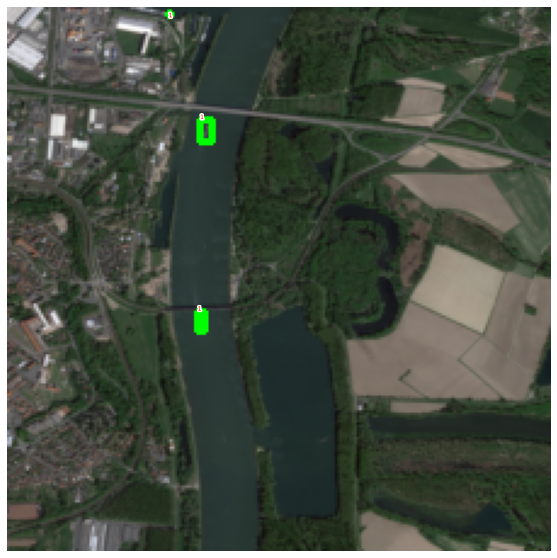

In [10]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

ds = OpenDataset(df=DF_PREPROCESSED_IMAGE_DETECTIONS)
img, tgt, __, __, __ = ds[1]
print(img.shape)
print(tgt['boxes'][1])
img = img.permute(1, 2, 0).numpy()
show(img, bbs=tgt['boxes'], texts=tgt['labels'], sz=10)

In [11]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(DF_PREPROCESSED_IMAGE_DETECTIONS.ImageID.unique(), test_size=TEST_SPLIT, random_state=99)
trn_df, val_df = DF_PREPROCESSED_IMAGE_DETECTIONS[DF_PREPROCESSED_IMAGE_DETECTIONS['ImageID'].isin(trn_ids)], DF_PREPROCESSED_IMAGE_DETECTIONS[DF_PREPROCESSED_IMAGE_DETECTIONS['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=test_ds.collate_fn, drop_last=True)

In [12]:
def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [13]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets, __, __, __ = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    input, targets, __, __, __ = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [14]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE,
                            momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
n_epochs = 15
log = Report(n_epochs)

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
torch.cuda.empty_cache()
import gc
gc.collect()
best_val_loss = 999999.99
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        val_loss=loss.item()
        log.record(pos, val_loss=val_loss, val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

        model_name = "model_faster_rcnn_epoch" + str(epoch+1) + "_batch" + str(BATCH_SIZE) + "_lr" + str(LEARNING_RATE) + ".pt"
        torch.save(model.state_dict(), os.path.join(MODEL_PATH, model_name))
    if (epoch+1)%(n_epochs//10)==0: log.report_avgs(epoch+1)

EPOCH: 1.000  trn_loc_loss: 0.285  val_loss: 1.101  val_loc_loss: 0.238  val_regr_loss: 0.120  trn_regr_loss: 0.144  trn_objectness_loss: 0.427  val_objectness_loss: 0.258  val_rpn_box_reg_loss: 0.485  trn_rpn_box_reg_loss: 0.458  trn_loss: 1.315  (139.40s - 1951.56s remaining)
EPOCH: 2.000  trn_loc_loss: 0.252  val_loss: 0.929  val_loc_loss: 0.194  val_regr_loss: 0.113  trn_regr_loss: 0.183  trn_objectness_loss: 0.295  val_objectness_loss: 0.226  val_rpn_box_reg_loss: 0.396  trn_rpn_box_reg_loss: 0.371  trn_loss: 1.101  (273.47s - 1777.58s remaining)
EPOCH: 3.000  trn_loc_loss: 0.239  val_loss: 0.891  val_loc_loss: 0.168  val_regr_loss: 0.103  trn_regr_loss: 0.208  trn_objectness_loss: 0.252  val_objectness_loss: 0.260  val_rpn_box_reg_loss: 0.360  trn_rpn_box_reg_loss: 0.338  trn_loss: 1.037  (407.64s - 1630.58s remaining)
EPOCH: 4.000  trn_loc_loss: 0.225  val_loss: 0.881  val_loc_loss: 0.188  val_regr_loss: 0.131  trn_regr_loss: 0.206  trn_objectness_loss: 0.224  val_objectness_los

100%|██████████| 116/116 [00:00<00:00, 1077.08it/s]


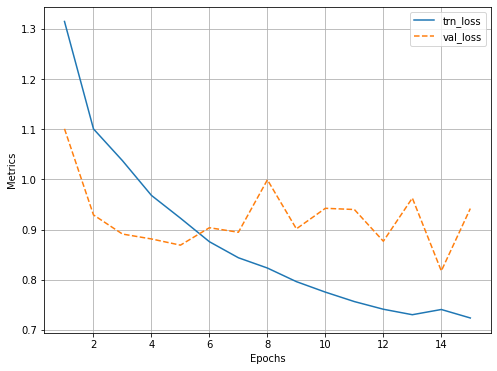

In [16]:
log.plot_epochs(['trn_loss','val_loss'])

In [24]:
model = get_model()
# Load weights from model with best val_loss
model.load_state_dict(torch.load(MODEL_PATH + "model_faster_rcnn_epoch14_batch1_lr0.002.pt"))
model = model.to(device)

In [25]:
TEST_PREPROCESSED_CSV_PATH = "../test/annotations_test.csv"
DF_PREPROCESSED_TEST_IMAGE_DETECTIONS = pd.read_csv(TEST_PREPROCESSED_CSV_PATH)

In [26]:
final_test_df = DF_PREPROCESSED_TEST_IMAGE_DETECTIONS

final_test_ds = OpenDataset(final_test_df, TEST_DATA_DIR)

final_test_loader = DataLoader(final_test_ds, batch_size=4, collate_fn=final_test_ds.collate_fn, drop_last=False)

torch.Size([3, 224, 224])
1780 1088

tensor[4] x∈[10.000, 20.000] μ=14.250 σ=4.646 [10.000, 16.000, 11.000, 20.000]

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


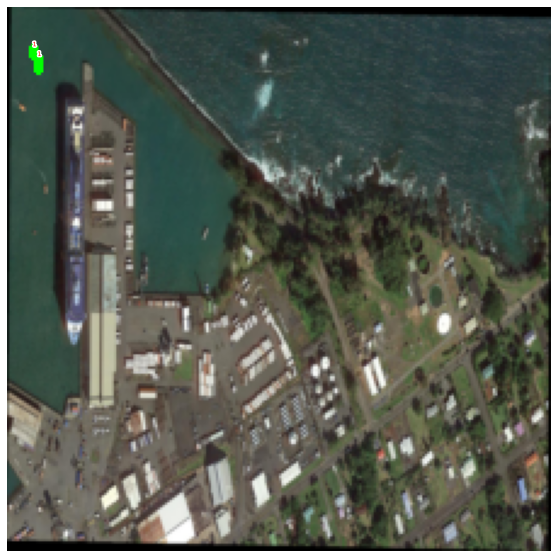

In [27]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

img, tgt, image_id, img_w, img_h = final_test_ds[0]
print(img.shape, img_w, img_h)
print(tgt['boxes'][1])
print(image_id)
img = img.permute(1, 2, 0).numpy()
show(img, bbs=tgt['boxes'], texts=tgt['labels'], sz=10)

In [28]:
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


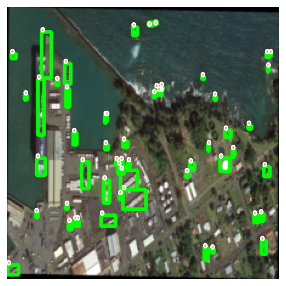

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


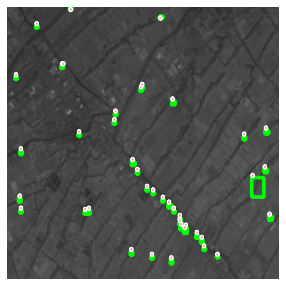

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


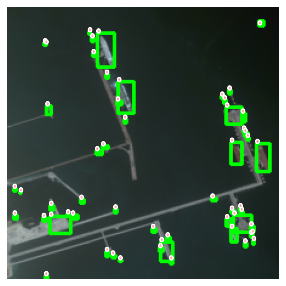

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


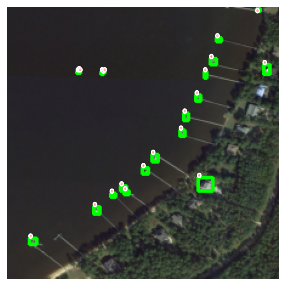

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


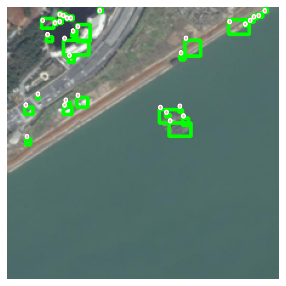

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


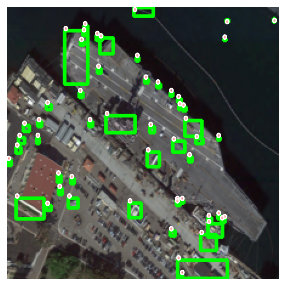

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


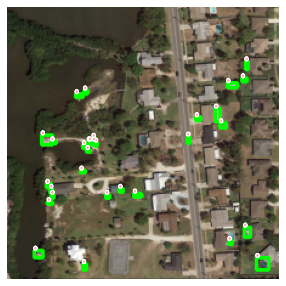

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


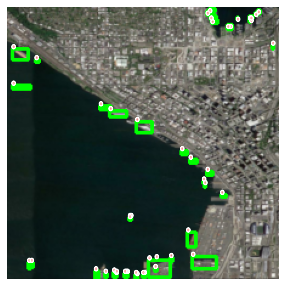

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


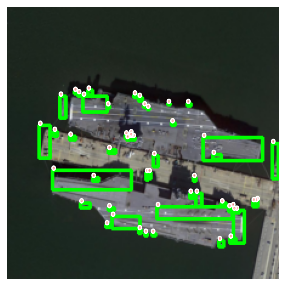

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


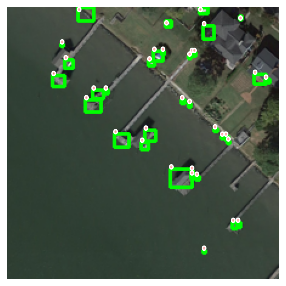

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


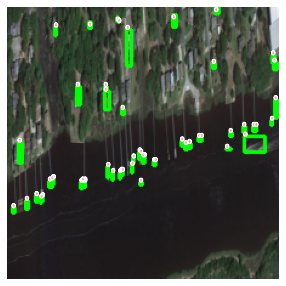

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


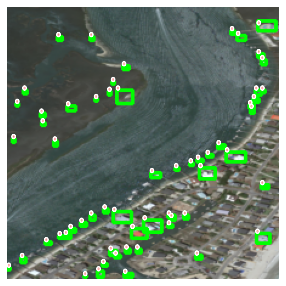

In [29]:
model.eval()
for ix, (images, targets, image_ids, __, __) in enumerate(final_test_loader):
    if ix==3: break
    images = [np.array(im) for im in images]
    images = np.array(images)
    images = torch.from_numpy(images)
    
    outputs = model(images.to(device))
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)

In [30]:
output_csv_path = "../submission.csv"
with open(output_csv_path, 'w', newline='') as csvfile:
    writer_object = csv.writer(csvfile)
    writer_object.writerow(['id','label'])
model.eval()
for ix, (images, targets, image_ids, img_ws, img_hs) in enumerate(final_test_loader):
    # if ix==3:
    #     break
    # print(ix)
    images = [np.array(im) for im in images]
    images = np.array(images)
    images = torch.from_numpy(images)
    
    outputs = model(images.to(device))
    for ix, output in enumerate(outputs):
        bbs, confs, __ = decode_output(output)
        with open(output_csv_path, 'a', newline='') as csvfile:
            writer_object = csv.writer(csvfile)
            new_row = []
            image_name = str(image_ids[ix]) + str(".png")
            new_row.append(image_name)
            label = ""
            assert (len(bbs) == len(confs))
            first_iter = True
            for (bb, conf) in zip(bbs, confs):
                if conf < 0.2:
                    continue
                bb[0] = ((bb[0] * np.float64(img_ws[ix])) / np.float64(224))
                bb[1] = ((bb[1] * np.float64(img_hs[ix])) / np.float64(224))
                bb[2] = ((bb[2] * np.float64(img_ws[ix])) / np.float64(224))
                bb[3] = ((bb[3] * np.float64(img_hs[ix])) / np.float64(224))
                if first_iter:
                    first_iter = False
                else:
                    label = label + ", "
                label = label + str(round(conf, 2)) + " " + str(round(bb[0], 1)) + " " + str(round(bb[1], 1)) + " " + str(round(bb[2], 1)) + " " + str(round(bb[3], 1))
            if label == "":
                label = "0 0 0 10 10"
            new_row.append(label)
            writer_object.writerow(new_row)
        # print(image_ids[ix], len(bbs), len(confs))